In [1]:
import os
import numpy as np 
import pandas as pd
# from google.colab import drive 
# drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/DSO560 NLP Group Project")

In [ ]:
data = pd.read_csv("./Reel Good Data (Title+Service).csv", index_col=0)
data.shape

## Data Cleaning & Prep 

#### Step 1: Cleaning/Grouping the Dependent Variable

Our intent here is to predict which steaming provider is likely to purchase a given content produced by a production house. First we need to understand how many categories are there.  

In [ ]:
data.groupby(['Service']).size().reset_index(name='counts')

***Clearly, there are too many providers and some of these providers can be grouped - Foe example "crunchyroll" and "crunchyroll free" can be grouped together (Since crunchyroll would have to liscence or buy exclusive rights in order to stream a given content on its platform regardless of weather its free to view or paid)***

The grouping rules followed were as follows:

1. Multiple providers listed for the same website/service. Eg. "crunchyroll" & "crunchyroll free".

2. Streming serivice providers with low number of titles were grouped with other providers - on the condition that the **content they were streming were similar**. Eg. "crunchyroll" & "funimation" both cater to an Anime watching audience, and both had less than 500 titles under each - therefore were grouped together. 

3. Domain Knowledge - From reserach we know that certain streamining providers operate under different entities. They were grouped together to lessen the sparsity of data under a given streming category. Eg. "disneyplus", "disneynow" & "disneynow free"

Detailed Grouping Referrence List is availble in Grouping&DataEliminationRef.csv

In [1]:
##Reading The grouped File in
import pandas as pd
import numpy as np
data = pd.read_csv("./ProjectData_Chris_1.csv")
data.shape

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(40651, 18)

**EDA on providers and the titles under each provider was performed. Data related to certain streaming providers was dropped during the EDA phase. The conditions used while dropping rows were as follows**:


1. Streming provider/Group (in cases where streming providers were grouped as a single entity) had less than 1000 titles in the underlying data. 

2. Streming provider Categories of "Rent or Buy" & "free" because they were not related or required for the business case we are solving for 

  The column **Selected Data** is a flag created that identifies rows that meet the above two conditions. 

  The column **Streming Group** is the Streming Group created or the streming provider(for cases that we could not group)


3. In addition to the above set, Any rows of data with a "What is it about?" blank was eliminated - as the document details were unavialble. 

In [1]:
data = data[(data['Selected Data']=='to_take') & (data["What it's about"].notna())]
data.shape

#### Step 2: Data Cleaning on the Documents 

We performed the following treatments for Data Passed to ML models

- Standardized the text to lowercase, lemmatizing it & removing stopwords

- Replace urls, hastags numbers, emails, emojis, currency_symbols

- Removed Punctuation

The resulting cleaned documents were stored in CleandDocs_ML field

In [3]:
#!pip install textacy
#!python -m spacy download en_core_web_sm

In [4]:
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
from textacy.preprocessing.remove import punctuation
#import en_core_web_sm
import spacy
from scipy.spatial.distance import cosine
import spacy
#Language class with the English model 'en_core_web_sm' is loaded
#!python -m spacy download en
import spacy
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

In [5]:
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])
def lemmatizer_new(My_text):
    doc = load_model(My_text)
    return(" ".join([token.lemma_ for token in doc]))

In [6]:
data['CleanedDocs_ML']=data["What it's about"].str.lower()
data["CleanedDocs_ML"] = data.CleanedDocs_ML.apply(urls).\
  apply(hashtags).\
  apply(numbers).\
  apply(currency_symbols).\
  apply(emojis).\
  apply(emails).\
  apply(punctuation).\
  apply(lemmatizer_new)
data["CleanedDocs_ML"] = data["CleanedDocs_ML"].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (all_stopwords)]))

data.CleanedDocs_ML[:5]

#Final check to see if any rows were dropped in preprocessing - Rows not processed by SPacy Language model may be dropped
data = data[(data['Selected Data']=='to_take') & (data["CleanedDocs_ML"].notna())]
data.to_csv('ProjectData_Saketh.csv')

In [7]:
data.shape

(40651, 19)

## Further Data Cleaning

In [2]:
##Reading The grouped File in

data = pd.read_csv("ProjectData_Saketh.csv")
data.shape

/Users/levitas/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(40651, 20)

In [3]:
data = data.drop(['Unnamed: 0', 'URL', 'Rated', 'Duration Year', 'Where to Watch', 'Rent or Buy Available', 'Has Tag'], axis = 1)
data['IMDB']=data['IMDB'].astype(float)
data.head(1)

,Title,Type,Service,IMDB,ReelGood,AgeRating,Released Year,Seasons,What it's about,Exclusive Service,Streaming Group,Selected Data,CleanedDocs_ML
0,Breaking Bad,tv,netflix,9.5,100.0,18,2008,5.0,"When Walter White, a New Mexico chemistry teac...",0,netflix,to_take,walter white new mexico chemistry teacher diag...


### One-Hot Encoding and Imputation

For the AgeRating and Type variables, because they are categorical variables, we will replace nulls values with the mode instead of the mean. Methods such as KNN are also an option for imputing these values.

In [4]:
data['AgeRating'] = data['AgeRating'].fillna(data['AgeRating'].mode()[0])

#values after imputation
data['AgeRating']

0        18
1        18
2        18
3        18
4        18
         ..
40646    18
40647    13
40648    13
40649     7
40650    18
Name: AgeRating, Length: 40651, dtype: object

In [5]:
data['AgeRating'].isna().sum()

0

In [6]:
set(data['AgeRating'].values)

{'13', '16', '18', '7', 'all'}

In [7]:
data['Type'] = data['Type'].fillna(data['Type'].mode()[0])

#values after imputation
data['Type']

0            tv
1            tv
2            tv
3            tv
4            tv
          ...  
40646    movies
40647    movies
40648    movies
40649    movies
40650    movies
Name: Type, Length: 40651, dtype: object

In [8]:
data['Type'].isna().sum()

0

In [9]:
set(data['Type'].values)

{'movies', 'tv'}

In [10]:
#creating dummy variables for the AgeRating column

data["AgeRating"] = data["AgeRating"].astype(str)
data["Type"] = data["Type"].astype(str)

data = pd.get_dummies(data, columns = ["AgeRating", "Type"])

data.columns

Index(['Title', 'Service', 'IMDB', 'ReelGood', 'Released Year', 'Seasons',
       'What it's about', 'Exclusive Service', 'Streaming Group',
       'Selected Data', 'CleanedDocs_ML', 'AgeRating_13', 'AgeRating_16',
       'AgeRating_18', 'AgeRating_7', 'AgeRating_all', 'Type_movies',
       'Type_tv'],
      dtype='object')

In [11]:
data = data.drop_duplicates()
data.shape

(40413, 18)

### Imputation Continued (Numerical Variables)

In the code below, we are replacing the null values with the mean of the variable for the select numerical variables. Note that there are other ways to impute these numbers (such as KNN), but for the sake of time and simplicity we will use the average.

In [12]:
mean_columns = ['IMDB', 'ReelGood','Released Year','Seasons']

#replacing all null values with the respective means for each variable
for i in mean_columns:
    data[i] = data[i].fillna(data[i].mean())
    print(data[i],"\n")

0        9.500000
1        9.300000
2        9.300000
3        9.200000
4        9.200000
           ...   
40646    6.202241
40647    6.202241
40648    6.202241
40649    6.202241
40650    6.202241
Name: IMDB, Length: 40413, dtype: float64 

0        100.000000
1         98.000000
2         98.000000
3         96.000000
4         96.000000
            ...    
40646     53.981645
40647     53.981645
40648     53.981645
40649     53.981645
40650     13.000000
Name: ReelGood, Length: 40413, dtype: float64 

0        2008
1        2011
2        2011
3        2013
4        2013
         ... 
40646    2015
40647    2014
40648    2014
40649    2011
40650    2016
Name: Released Year, Length: 40413, dtype: int64 

0        5.00000
1        8.00000
2        8.00000
3        4.00000
4        4.00000
          ...   
40646    4.13987
40647    4.13987
40648    4.13987
40649    4.13987
40650    4.13987
Name: Seasons, Length: 40413, dtype: float64 



In [13]:
#confirming that there are no nulls left in those columns
for i in mean_columns:
    print(data[i].isna().sum())

0
0
0
0


### De-duping

In [15]:
data.columns

Index(['Title', 'Service', 'IMDB', 'ReelGood', 'Released Year', 'Seasons',
       'What it's about', 'Exclusive Service', 'Streaming Group',
       'Selected Data', 'CleanedDocs_ML', 'AgeRating_13', 'AgeRating_16',
       'AgeRating_18', 'AgeRating_7', 'AgeRating_all', 'Type_movies',
       'Type_tv'],
      dtype='object')

In [16]:
#df=data[['CleanedDocs_ML','Streaming Group','Released Year']].drop_duplicates()
df1=data.groupby(['CleanedDocs_ML','Streaming Group','AgeRating_13', 'AgeRating_16',
       'AgeRating_18', 'AgeRating_7', 'AgeRating_all', 'Type_movies',
       'Type_tv'])['IMDB','ReelGood', 'Released Year', 'Exclusive Service'].max()
#df1=pd.DataFrame(df1)
data = df1
data.columns

<ipython-input-16-5fca91199531>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1=data.groupby(['CleanedDocs_ML','Streaming Group','AgeRating_13', 'AgeRating_16',


Index(['IMDB', 'ReelGood', 'Released Year', 'Exclusive Service'], dtype='object')

In [19]:
data2 = data.reset_index()
data2.head()

,CleanedDocs_ML,Streaming Group,AgeRating_13,AgeRating_16,AgeRating_18,AgeRating_7,AgeRating_all,Type_movies,Type_tv,IMDB,ReelGood,Released Year,Exclusive Service
0,100th anniversary original voyage modern luxur...,hoopla/kanopy,0,0,1,0,0,1,0,1.6,36.0,2010,0
1,100th anniversary original voyage modern luxur...,plex_free,0,0,1,0,0,1,0,1.6,36.0,2010,0
2,100th anniversary original voyage modern luxur...,plutotv,0,0,1,0,0,1,0,1.6,36.0,2010,0
3,100th anniversary original voyage modern luxur...,tubi_tv,0,0,1,0,0,1,0,1.6,36.0,2010,0
4,100th anniversary original voyage modern luxur...,vudu_free,0,0,1,0,0,1,0,1.6,36.0,2010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35719,zooni ali beg kajol blind kashmiri girl travel...,amazon,0,0,0,1,0,1,0,7.2,79.0,2006,0
35720,ömer police officer death fiancée suffer great...,netflix,0,0,1,0,0,0,1,7.2,66.0,2014,1
35721,ötztal alp number year ago neolithic clan lead...,hoopla/kanopy,0,0,1,0,0,1,0,6.3,61.0,2017,0
35722,žižek trail thinker crisscross globe race new ...,fandor,0,0,1,0,0,1,0,7.3,58.0,2005,1


In [20]:
data = data2

## Exclusive Content

In [21]:
###Two types of Models to be built - one a Multiclass model for exclusive content & a Multilabel model for non-exclusive content

###For Exlusive content
data=data[data['Exclusive Service']==1]

#Checking if each exclusive stremer has at least 100 titles to ensure there is suffecient data for the model 
#We are picking streamers only with 100 titles or more

groups_exclusive=data.groupby('Streaming Group')['CleanedDocs_ML'].count()
groups_exclusive=pd.DataFrame(groups_exclusive)
groups_exclusive_totake=groups_exclusive[groups_exclusive['CleanedDocs_ML']>100].index
data=data[data['Streaming Group'].isin(groups_exclusive_totake)]
labels = data['Streaming Group'].unique ()
i = 0
idx2class = {}
class2idx = {}
for tp in labels:
    idx2class[i] = tp
    class2idx[tp]= i
    i+= 1
idx2class #For decoding
class2idx #for encoding

data['DV']=data['Streaming Group'].map(class2idx)
data.shape
# # # get all genre tags in a list
# # # all_dv = sum(data['DV'],[])
# # # len(set(all_dv))


(2213, 14)

In [22]:
#import packages
import pandas as pd
import nltk as nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from nltk import word_tokenize 
import string
import re
import multiprocessing
import gensim
from gensim.models.keyedvectors import KeyedVectors
import pickle
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


[nltk_data] Downloading package punkt to /Users/levitas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/levitas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# ### Preparing Vocab Dictionary - for Count & TFIDF only
stopwords1 = stopwords.words('english')

#stopwords1.extend(stop['Stopword'])
from nltk.util import ngrams
from collections import Counter
from nltk import word_tokenize 
da=(' '.join(filter(None,data["CleanedDocs_ML"]))).lower()
tokens = word_tokenize(da)
tokens = [w for w in tokens if w not in stopwords1]
filter_df =pd.DataFrame()
uni_grams = list(ngrams(tokens, 1))
counter = Counter(uni_grams)
filter_df['fnames']=[' '.join(i) for i in counter.keys()]
filter_df[0]=counter.values()

###Change the number in the line below to limit vocab based on freq (To be tried to see if it improves model)
fnames=pd.DataFrame(filter_df[filter_df[0]>1]['fnames'])
print("Vocab Size from Data is: " + str(fnames['fnames'].size))
fnames.to_csv(r"complete_data_dictionary")
fnames=fnames.reset_index(drop=True)
vocab_d=dict(zip(fnames["fnames"], fnames.index))
pickle.dump(vocab_d,open('full_data_vocab','wb'))
#
del fnames, da,filter_df, counter, tokens, uni_grams,
del stopwords1

Vocab Size from Data is: 5522


# Feature Engineering

In [24]:
#Source: https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4
#Source: https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.key_to_index for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.key_to_index]
    return np.mean(model[doc], axis=0)

### Part 1: TFIDF Vectorizer

In [25]:
data["CleanedDocs_ML"]=data["CleanedDocs_ML"].astype(str)
##to handle spaces in the end of text in case
data["CleanedDocs_ML"]=data["CleanedDocs_ML"].str.lstrip() 
# data_with_id.loc[data_with_id.Text.str.lower().isin(stopwords1), 'Text'] = 'is stopword'


vocabulary_words = pickle.load(open(r'full_data_vocab','rb'))


tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', vocabulary= vocabulary_words)
tfidf_vect.fit(data["CleanedDocs_ML"])
feature_names_dat = tfidf_vect.get_feature_names()
df1 =  tfidf_vect.transform(data["CleanedDocs_ML"])
TfidfData = pd.DataFrame(df1.toarray(), columns=feature_names_dat)
#TfidfData.to_csv(r"tfidf_vectorizer_on_full_data_vocab.csv",index=False, encoding="utf-8")
len(TfidfData)

#ADD any other coulmns for training as you see fit
#TfidfData['AgeRating']=data['AgeRating']

/Users/levitas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


2213

### Part 2: Google Word2Vec

In [27]:
#W2V using Google Corpus
da=(' '.join(filter(None, data["CleanedDocs_ML"]))).lower()
tokens = word_tokenize(da)
model = gensim.models.KeyedVectors.load_word2vec_format(r'./GoogleNews-vectors-negative300.bin.gz', binary=True)


df1 = pd.DataFrame(data[["CleanedDocs_ML"]])
df1['totake']=pd.DataFrame(df1["CleanedDocs_ML"].apply(lambda x:has_vector_representation(model,x)))
df1['joincol']=df1.index
data_t = df1[df1['totake']]
data_l = df1[df1['totake']==False]
#data_l = data_l['joincol']

data_l=data_l.reset_index(drop=True)
data_t=data_t.reset_index(drop=True)

text_list = [text for text in data_t['CleanedDocs_ML']]
len(text_list)
data_t['filtered_text'], text_list = filter_docs(data_t['CleanedDocs_ML'], text_list, lambda doc: has_vector_representation(model, doc))


#Final out is in data filtered text
vector = []
for doc in data_t['filtered_text']: # append the vector for each document
    vector.append(document_vector(model, doc))
    
df = np.array(vector)
W2V300Data=pd.DataFrame(data=df[0:,0:], index=[i for i in range(df.shape[0])], columns=['f'+str(i) for i in range(df.shape[1])])


W2V300Data['joincol']= data_t['joincol']

l= ['f'+str(i) for i in range(df.shape[1])]
for col in l:
    data_l[col] = 0
data_l=data_l.drop(columns=['CleanedDocs_ML', 'totake'])

print(W2V300Data.shape)
print("Records without Vecotrs Detected: " + str(data_l.shape))
W2V300Data=pd.concat([W2V300Data,data_l], ignore_index=True)
print("There are "+str(W2V300Data['joincol'].nunique())+" Unique records in Final DataFrame")
W2V300Data = W2V300Data.set_index('joincol')
W2V300Data = W2V300Data.sort_index(axis = 0) 

print("Please QC the number of rows to be common before use. The shapes are defined below:")
print("Original Data Shape: "+ str(data.shape)+" Word 2 Vec Vectorizer Shape is: "+str(W2V300Data.shape))
#W2V300Data.to_csv(r"FeatureSets_New/W2V300Data.csv",index=False, encoding="utf-8")

len(W2V300Data)

#ADD any other coulmns for training as you see fit
#W2V300Data['AgeRating']=data['AgeRating']

0 docs removed
(2213, 301)
Records without Vecotrs Detected: (0, 301)
There are 2213 Unique records in Final DataFrame
Please QC the number of rows to be common before use. The shapes are defined below:
Original Data Shape: (2213, 14) Word 2 Vec Vectorizer Shape is: (2213, 300)


2213

In [88]:
#potential variables to run:

#W2V300Data['IMDB']=data['IMDB']
#W2V300Data['Type_movies']=data['Type_movies']
#W2V300Data['Type_tv']=data['Type_tv']
#W2V300Data['ReelGood']=data['ReelGood']
#W2V300Data['Released Year']=data['Released Year']
#W2V300Data['AgeRating_13']=data['AgeRating_13']
#W2V300Data['AgeRating_16']=data['AgeRating_16']
#W2V300Data['AgeRating_18']=data['AgeRating_18']
#W2V300Data['AgeRating_7']=data['AgeRating_7']
#W2V300Data['AgeRating_all']=data['AgeRating_all']


# ML Model Building

### AutoML from h2o

In [90]:
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
########H2O
import pandas as pd
import numpy as np
import nltk as nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from nltk import word_tokenize 
import string
import multiprocessing
import gensim
from gensim.models.keyedvectors import KeyedVectors
import pickle
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import OneHotEncoder

#Change the following line depending on what you are running
#Eg - Replace TfidfData with W2V300Data  to try how different featuresets perform - 
#or if you change to TFIDF with 1 other columns eg W2V_withAge

X_train, X_test, y_train, y_test = train_test_split(TfidfData, data['DV'], test_size=0.25, random_state=42, stratify = data['DV'] )

tr=pd.DataFrame(X_train)
tr=tr.reset_index(drop=True)
#tr=tr.drop(columns=['joincol'],axis=1)
predictors=list(tr.columns)
y_train=pd.DataFrame(y_train)
y_train=y_train.reset_index(drop=True)
tr['DV']=y_train

ts=pd.DataFrame(X_test)
ts=ts.reset_index(drop=True)
#ts=ts.drop(columns=['joincol'],axis=1)
y_test=pd.DataFrame(y_test)
y_test=y_test.reset_index(drop=True)
ts['DV']=y_test


h2o.init()
tr_h2o = h2o.H2OFrame(tr)
tr_h2o['DV'] = tr_h2o['DV'].asfactor()

ts_h2o = h2o.H2OFrame(ts)
ts_h2o['DV'] = ts_h2o['DV'].asfactor()


[nltk_data] Downloading package punkt to /Users/levitas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/levitas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 45 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_levitas_s0jbo4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.867 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [91]:
#Auto ML Run # Set max_runtime_secs to whatever makes sense. 
aml = H2OAutoML(max_models = 20,max_runtime_secs=1800, seed = 1, export_checkpoints_dir = './dummy/')
aml.train(x = predictors, y ='DV',training_frame=tr_h2o)
#Get the leaderboard
lb = aml.leaderboard

AutoML progress: |
13:30:37.494: _train param, Dropping bad and constant columns: [pope, fare, hamlet, flicker, clinton, tripathi, halo, urge, rider, aviv, photographers, graduation, alaska, vik, tel, daring, hermit, rap, solid, antonio, gladiator, neutral, carnival, apparent, zelda, kotona, amusing, talisman, weir, hang, 12th, daiki, heartedly, golf, kindaor, yoman, barricade, ludiro, tattooed, kassler, gibson, embarrassment, zhen, stasis, freshman, halt, fårö, v, exciting, regain, arch, standard, waco, mobeen, pryor, thx, flamboyant, chill, entangle, demise, pott, counterpoint, boyhood, whirlwind, pad, nazira, copycat, offender, kuni, harumi, stefan, che, ito, invitation, rajaram, andrew, sand, coleman, parimal, haru, orlof, patiently, darren, capitalism, surveillance, clarinet, snoop, yuliy, stallone, haiti, marcos, victory, rick, linda, jaeger, vikramaditya, suraj, stoneman, chariot, razia, feminism, hopeless, milda, creepy, albeit, slacker, riff, morag, injustice, atsushi, compost

██████████
13:31:23.773: _train param, Dropping unused columns: [pope, fare, hamlet, flicker, clinton, tripathi, halo, urge, rider, aviv, photographers, graduation, alaska, vik, tel, daring, hermit, rap, solid, antonio, gladiator, neutral, carnival, apparent, zelda, kotona, amusing, talisman, weir, hang, 12th, daiki, heartedly, golf, kindaor, yoman, barricade, ludiro, tattooed, kassler, gibson, embarrassment, zhen, stasis, freshman, halt, fårö, v, exciting, regain, arch, standard, waco, mobeen, pryor, thx, flamboyant, chill, entangle, demise, pott, counterpoint, boyhood, whirlwind, pad, nazira, copycat, offender, kuni, harumi, stefan, che, ito, invitation, rajaram, andrew, sand, coleman, parimal, haru, orlof, patiently, darren, capitalism, surveillance, clarinet, snoop, yuliy, stallone, haiti, marcos, victory, rick, linda, jaeger, vikramaditya, suraj, stoneman, chariot, razia, feminism, hopeless, milda, creepy, albeit, slacker, riff, morag, injustice, atsushi, compost, shah, catholicis

In [92]:
model = aml.leader
# download the model built above to your local machine - to reuse & Reproduce results on Future data
my_local_model = h2o.download_model(model)
my_local_model

'/Users/levitas/Desktop/StackedEnsemble_BestOfFamily_1_AutoML_10_20220509_133036'

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/levitas/opt/anaconda3/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'IMDB' has levels not trained on: ["4.4", "4.5", "4.9", "7.7", "8.1"]
  warnings.warn(w)



Testing Results of the trained model: 

Accuracy :  0.5487364620938628

Baseline Accuracy :  0.4223826714801444

Confusion Matrix :
 [[191  10  30   0   3   0]
 [ 32   7  24   2   0   2]
 [ 34   2  43   3   1   0]
 [ 41   7  19   4   0   0]
 [ 43   6  14   1   5   0]
 [ 21   1   5   0   3   0]]

Classification Report :
               precision    recall  f1-score   support

           0       0.53      0.82      0.64       234
           1       0.21      0.10      0.14        67
           2       0.32      0.52      0.39        83
           3       0.40      0.06      0.10        71
           4       0.42      0.07      0.12        69
           5       0.00      0.00      0.00        30

    accuracy                           0.45       554
   macro avg       0.31      0.26      0.23       554
weighted avg       0.40      0.45      0.37       554



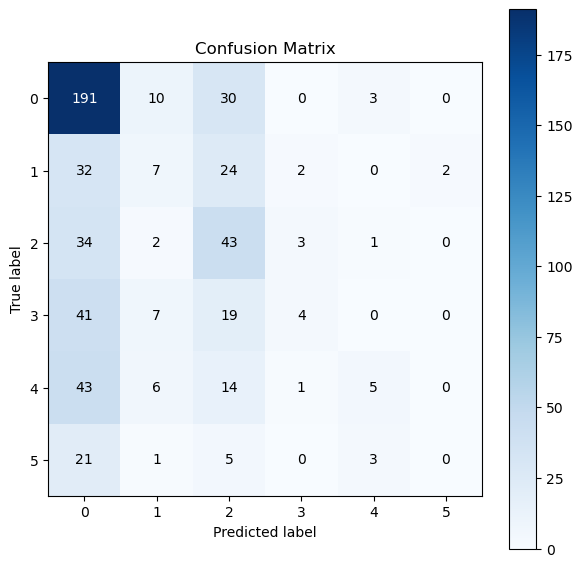

In [93]:
#h2o.init()
# upload the model that you just downloded above
# to the H2O cluster
#need to update this model with the output from the above cell for each model that is run
uploaded_model = h2o.upload_model('/Users/levitas/Desktop/StackedEnsemble_BestOfFamily_1_AutoML_10_20220509_133036')
model=uploaded_model
# For Classification
import scikitplot as skplt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt

# Predict with the best model.
predicted_y = model.predict(ts_h2o.drop('DV'))

predicted_data = predicted_y.as_data_frame()
valid_dataset = ts_h2o.as_data_frame()


# Evaluate the skill of the Trained model
acc                 = accuracy_score(valid_dataset['DV'], predicted_data['predict'])
baseline_acc = accuracy_score(valid_dataset['DV'], [0 for i in range(len(predicted_data))])
classReport         = classification_report(valid_dataset['DV'], predicted_data['predict'])
confMatrix          = confusion_matrix(valid_dataset['DV'], predicted_data['predict']) 
        
print(); print('Testing Results of the trained model: ')
print(); print('Accuracy : ', 1-acc)
print(); print('Baseline Accuracy : ', baseline_acc)
print(); print('Confusion Matrix :\n', confMatrix)
print(); print('Classification Report :\n',classReport)

# Confusion matrix
skplt.metrics.plot_confusion_matrix(valid_dataset['DV'], predicted_data['predict'], figsize=(7,7)); plt.show()

In [34]:
idx2class

{0: 'netflix',
 1: 'criterion_channel',
 2: 'fandor',
 3: 'hoopla/kanopy',
 4: 'amazon',
 5: 'epix'}

## Non-Exclusive Content Models

In [35]:
########H2O
import pandas as pd
import numpy as np
import nltk as nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from nltk import word_tokenize 
import string
import multiprocessing
import gensim
from gensim.models.keyedvectors import KeyedVectors
import pickle
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import re

data = pd.read_csv('ProjectData_Saketh.csv')

##
# Data cleaning steps from earlier
data = data.drop(['Unnamed: 0', 'URL', 'Rated', 'Duration Year', 'Where to Watch', 'Rent or Buy Available', 'Has Tag'], axis = 1)
data['IMDB']=data['IMDB'].astype(float)
data['AgeRating'] = data['AgeRating'].fillna(data['AgeRating'].mode()[0])
data['Type'] = data['Type'].fillna(data['Type'].mode()[0])
data["AgeRating"] = data["AgeRating"].astype(str)
data["Type"] = data["Type"].astype(str)
data = pd.get_dummies(data, columns = ["AgeRating", "Type"])
data = data.drop_duplicates()
mean_columns = ['IMDB', 'ReelGood','Released Year','Seasons']
for i in mean_columns:
    data[i] = data[i].fillna(data[i].mean())
df1=data.groupby(['CleanedDocs_ML','Streaming Group','AgeRating_13', 'AgeRating_16',
       'AgeRating_18', 'AgeRating_7', 'AgeRating_all', 'Type_movies',
       'Type_tv'])['IMDB','ReelGood', 'Released Year', 'Exclusive Service'].max()
data = df1    
data2 = data.reset_index()
data = data2
##

data_ne=data[data['Exclusive Service']==0]
data_ne.reset_index(inplace=True)
tst= data_ne[['CleanedDocs_ML','Streaming Group']].drop_duplicates()
tst.shape
#da=(' '.join(filter(None, data_ne["CleanedDocs_ML"]))).lower()

[nltk_data] Downloading package punkt to /Users/levitas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/levitas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/levitas/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-35-4c5b12eebc1c>:35: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1=data.groupby(['CleanedDocs_ML','Streaming Group','AgeRating_13', 'AgeRating_16',


(33212, 2)

In [36]:
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
data_ne_t = pd.DataFrame(enc.fit_transform(data_ne[['Streaming Group']]).toarray(),columns= enc.get_feature_names(['Streaming Group']))
#print(data_ne_t.shape)
#data_ne_t['CleanedDocs_ML']=data_ne['CleanedDocs_ML']
#print(data_ne['CleanedDocs_ML'].shape)
data_ne_t=pd.concat([data_ne['CleanedDocs_ML'],data_ne_t],axis=1)
data_ne_t = data_ne_t.drop_duplicates(ignore_index=True)
#data_ne_t.to_csv('Check_df.csv')
print(data_ne_t.shape)
#data=data_ne_t
data_ne_t.columns


(33212, 21)


/Users/levitas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Index(['CleanedDocs_ML', 'Streaming Group_amazon',
       'Streaming Group_cinemax/showtime/starz',
       'Streaming Group_criterion_channel',
       'Streaming Group_crunchyroll/funimation', 'Streaming Group_disney',
       'Streaming Group_epix', 'Streaming Group_fandor',
       'Streaming Group_fubo_tv', 'Streaming Group_hbo',
       'Streaming Group_hoopla/kanopy', 'Streaming Group_hulu_plus',
       'Streaming Group_imdb_tv', 'Streaming Group_netflix',
       'Streaming Group_peacock', 'Streaming Group_plex_free',
       'Streaming Group_plutotv', 'Streaming Group_popcornflix',
       'Streaming Group_sundance', 'Streaming Group_tubi_tv',
       'Streaming Group_vudu_free'],
      dtype='object')

In [37]:
data_ne_t = data_ne_t.groupby('CleanedDocs_ML',as_index=False).max()
print(data_ne_t.shape)
data_ne_t = data_ne_t.merge(data_ne['CleanedDocs_ML'].drop_duplicates(), how='left', on='CleanedDocs_ML')
data=data_ne_t

(18431, 21)


### W2V for Non-Exclusive Content

In [38]:
#Source: https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4
#Source: https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.key_to_index for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.key_to_index]
    return np.mean(model[doc], axis=0)


#W2V using Google Corpus
da=(' '.join(filter(None, data["CleanedDocs_ML"]))).lower()
tokens = word_tokenize(da)
model = gensim.models.KeyedVectors.load_word2vec_format(r'./GoogleNews-vectors-negative300.bin.gz', binary=True)


df1 = pd.DataFrame(data[["CleanedDocs_ML"]])
df1['totake']=pd.DataFrame(df1["CleanedDocs_ML"].apply(lambda x:has_vector_representation(model,x)))
df1['joincol']=df1.index
data_t = df1[df1['totake']]
data_l = df1[df1['totake']==False]
#data_l = data_l['joincol']

data_l=data_l.reset_index(drop=True)
data_t=data_t.reset_index(drop=True)

text_list = [text for text in data_t['CleanedDocs_ML']]
len(text_list)
data_t['filtered_text'], text_list = filter_docs(data_t['CleanedDocs_ML'], text_list, lambda doc: has_vector_representation(model, doc))


#Final out is in data filtered text
vector = []
for doc in data_t['filtered_text']: # append the vector for each document
    vector.append(document_vector(model, doc))
    
df = np.array(vector)
W2V300Data=pd.DataFrame(data=df[0:,0:], index=[i for i in range(df.shape[0])], columns=['f'+str(i) for i in range(df.shape[1])])


W2V300Data['joincol']= data_t['joincol']

l= ['f'+str(i) for i in range(df.shape[1])]
for col in l:
    data_l[col] = 0
data_l=data_l.drop(columns=['CleanedDocs_ML', 'totake'])

print(W2V300Data.shape)
print("Records without Vecotrs Detected: " + str(data_l.shape))
W2V300Data=pd.concat([W2V300Data,data_l], ignore_index=True)
print("There are "+str(W2V300Data['joincol'].nunique())+" Unique records in Final DataFrame")
W2V300Data = W2V300Data.set_index('joincol')
W2V300Data = W2V300Data.sort_index(axis = 0) 

print("Please QC the number of rows to be common before use. The shapes are defined below:")
print("Original Data Shape: "+ str(data.shape)+" Word 2 Vec Vectorizer Shape is: "+str(W2V300Data.shape))
#W2V300Data.to_csv(r"FeatureSets_New/W2V300Data.csv",index=False, encoding="utf-8")

len(W2V300Data)

#ADD any other coulmns for training as you see fit
#W2V300Data['AgeRating']=data['AgeRating']

0 docs removed
(18431, 301)
Records without Vecotrs Detected: (0, 301)
There are 18431 Unique records in Final DataFrame
Please QC the number of rows to be common before use. The shapes are defined below:
Original Data Shape: (18431, 21) Word 2 Vec Vectorizer Shape is: (18431, 300)


18431

### TFIDF for Non-Exclusive Content

In [39]:
# ### Preparing Vocab Dictionary - for Count & TFIDF only
stopwords1 = stopwords.words('english')

#stopwords1.extend(stop['Stopword'])
from nltk.util import ngrams
from collections import Counter
from nltk import word_tokenize 
da=(' '.join(filter(None,data["CleanedDocs_ML"]))).lower()
tokens = word_tokenize(da)
tokens = [w for w in tokens if w not in stopwords1]
filter_df =pd.DataFrame()
uni_grams = list(ngrams(tokens, 1))
counter = Counter(uni_grams)
filter_df['fnames']=[' '.join(i) for i in counter.keys()]
filter_df[0]=counter.values()

###Change the number in the line below to limit vocab based on freq (To be tried to see if it improves model)
fnames=pd.DataFrame(filter_df[filter_df[0]>1]['fnames'])
print("Vocab Size from Data is: " + str(fnames['fnames'].size))
fnames.to_csv(r"complete_data_dictionary")
fnames=fnames.reset_index(drop=True)
vocab_d=dict(zip(fnames["fnames"], fnames.index))
pickle.dump(vocab_d,open('full_data_vocab','wb'))
#
del fnames, da,filter_df, counter, tokens, uni_grams,
del stopwords1


data["CleanedDocs_ML"]=data["CleanedDocs_ML"].astype(str)
##to handle spaces in the end of text in case
data["CleanedDocs_ML"]=data["CleanedDocs_ML"].str.lstrip() 
# data_with_id.loc[data_with_id.Text.str.lower().isin(stopwords1), 'Text'] = 'is stopword'


vocabulary_words = pickle.load(open(r'full_data_vocab','rb'))


tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', vocabulary= vocabulary_words)
tfidf_vect.fit(data["CleanedDocs_ML"])
feature_names_dat = tfidf_vect.get_feature_names()
df1 =  tfidf_vect.transform(data["CleanedDocs_ML"])
TfidfData = pd.DataFrame(df1.toarray(), columns=feature_names_dat)
#TfidfData.to_csv(r"tfidf_vectorizer_on_full_data_vocab.csv",index=False, encoding="utf-8")
len(TfidfData)

#ADD any other coulmns for training as you see fit
#TfidfData['AgeRating']=data['AgeRating']

Vocab Size from Data is: 19595


/Users/levitas/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


18431

#### In the step below, you can replace W2V300Data with any DF of your choice with the features of your choice:
#### Replace the y/DV var
#####    'Streaming Group_amazon',
#####    'Streaming Group_cinemax/showtime/starz',
#####    'Streaming Group_criterion_channel',
#####    'Streaming Group_crunchyroll/funimation', 'Streaming Group_disney',
#####    'Streaming Group_epix', 'Streaming Group_fandor',
#####    'Streaming Group_fubo_tv', 'Streaming Group_hbo',
#####    'Streaming Group_hoopla/kanopy', 'Streaming Group_hulu_plus',
#####    'Streaming Group_imdb_tv', 'Streaming Group_netflix',
#####    'Streaming Group_peacock', 'Streaming Group_plex_free',
#####    'Streaming Group_plutotv', 'Streaming Group_popcornflix',
#####    'Streaming Group_sundance', 'Streaming Group_tubi_tv',
#####    'Streaming Group_vudu_free'

In [26]:
# W2V300Data['IMDB']=data_ne['IMDB']
# W2V300Data['Type_movies']=data_ne['Type_movies']
# W2V300Data['Type_tv']=data_ne['Type_tv']
# W2V300Data['ReelGood']=data_ne['ReelGood']
# W2V300Data['Released Year']=data_ne['Released Year']
# W2V300Data['AgeRating_13']=data_ne['AgeRating_13']
# W2V300Data['AgeRating_16']=data_ne['AgeRating_16']
# W2V300Data['AgeRating_18']=data_ne['AgeRating_18']
# W2V300Data['AgeRating_7']=data_ne['AgeRating_7']
# W2V300Data['AgeRating_all']=data_ne['AgeRating_all']
#W2V300Data = W2V300Data.drop(['IMDB', 'Type_movies', 'Type_tv', 'ReelGood', 'Released Year', 'AgeRating_13', 'AgeRating_16', 'AgeRating_18', 'AgeRating_7', 'AgeRating_all'], 1)

In [150]:
#for each streaming group, need to update the below line of code for the column and the stratify arguments
X_train, X_test, y_train, y_test = train_test_split(W2V300Data, data['Streaming Group_vudu_free'], test_size=0.25, random_state=42, stratify = data['Streaming Group_vudu_free'])
tr=pd.DataFrame(X_train)
tr=tr.reset_index(drop=True)
#tr=tr.drop(columns=['joincol'],axis=1)
predictors=list(tr.columns)
y_train=pd.DataFrame(y_train)
y_train=y_train.reset_index(drop=True)
tr['DV']=y_train

ts=pd.DataFrame(X_test)
ts=ts.reset_index(drop=True)
#ts=ts.drop(columns=['joincol'],axis=1)
y_test=pd.DataFrame(y_test)
y_test=y_test.reset_index(drop=True)
ts['DV']=y_test


h2o.init()
tr_h2o = h2o.H2OFrame(tr)
tr_h2o['DV'] = tr_h2o['DV'].asfactor()

ts_h2o = h2o.H2OFrame(ts)
ts_h2o['DV'] = ts_h2o['DV'].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,7 hours 0 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_levitas_d5873t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.755 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [151]:
####Specify max models to control for time-

#Auto ML Run # Set max_runtime_secs to whatever makes sense. 
aml = H2OAutoML(max_models = 20,max_runtime_secs=1800, seed = 1, export_checkpoints_dir = './dummy/')
aml.train(x = predictors, y ='DV',training_frame=tr_h2o)
#Get the leaderboard
lb = aml.leaderboard

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


In [152]:
#Get the leaderboard
lb = aml.leaderboard
#Display the leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_24_20220509_212303,0.519184,0.290946,0.0936757,0.490391,0.279025,0.0778547
XGBoost_1_AutoML_24_20220509_212303,0.512268,0.3348,0.0880683,0.492869,0.29044,0.0843556
GBM_1_AutoML_24_20220509_212303,0.502002,0.297553,0.086932,0.499763,0.280956,0.078936
StackedEnsemble_BestOfFamily_1_AutoML_24_20220509_212303,0.488338,0.291201,0.0829519,0.4956,0.279111,0.0779032


In [153]:
model = aml.leader
# download the model built above to your local machine - to reuse & Reproduce results on Future data
my_local_model = h2o.download_model(model)
my_local_model

'/Users/levitas/Desktop/GLM_1_AutoML_24_20220509_212303'

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,7 hours 2 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_levitas_d5873t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.721 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

Testing Results of the trained model: 

Accuracy :  0.59765625

Baseline Accuracy :  0.9149305555555556

Confusion Matrix :
 [[1612 2604]
 [ 150  242]]

Classification Report :
               precision    recall  f1-score   support

           0       0.91      0.38      0.54      4216
           1       0.09      0.62      0.15       392

    accuracy                           0.40      4608
   macro avg       0.50      0.50      0.34      4608
weighted avg       0.84      0.40      0.51      4608



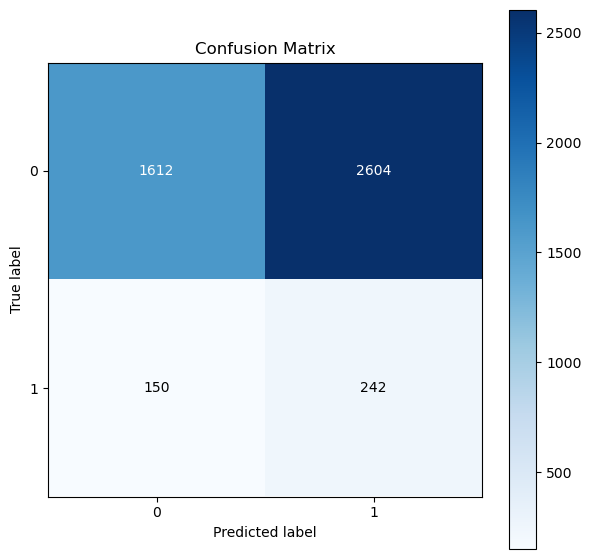

In [154]:
h2o.init()
# upload the model that you just downloded above
# to the H2O cluster
#need to update this model with the output from the above cell for each model that is run
uploaded_model = h2o.upload_model('/Users/levitas/Desktop/GLM_1_AutoML_24_20220509_212303')
model=uploaded_model
# For Classification
import scikitplot as skplt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt

# Predict with the best model.
predicted_y = model.predict(ts_h2o.drop('DV'))

predicted_data = predicted_y.as_data_frame()
valid_dataset = ts_h2o.as_data_frame()

#Tweak Cutoff based on Event rate of the column - Optional
#predicted_data['predict'] = np.where(predicted_data['p1']>=0.16,1,0)

# Evaluate the skill of the Trained model
acc                 = accuracy_score(valid_dataset['DV'], predicted_data['predict'])
baseline_acc = accuracy_score(valid_dataset['DV'], [0 for i in range(len(predicted_data))])
classReport         = classification_report(valid_dataset['DV'], predicted_data['predict'])
confMatrix          = confusion_matrix(valid_dataset['DV'], predicted_data['predict']) 
        
print(); print('Testing Results of the trained model: ')
print(); print('Accuracy : ', 1-acc)
print(); print('Baseline Accuracy : ', baseline_acc)
print(); print('Confusion Matrix :\n', confMatrix)
print(); print('Classification Report :\n',classReport)

# Confusion matrix
skplt.metrics.plot_confusion_matrix(valid_dataset['DV'], predicted_data['predict'], figsize=(7,7)); plt.show()